# Example how to use Paituli STAC with Python

This example shows how to use [Paituli STAC catalogue](https://paituli.csc.fi/geoserver/ogc/stac/v1) with Python.  

This workflow is meant for processing big raster datasets, also with good support for time series. The main idea is to first define the search and processing as process graph. The downloading and processing is done lazily at the end, so that only needed data (good enough cloud-free image, only needed bands and area) is downloaded. The libraries take care of data download, so you do not need to know about file paths. These tools work best when data is provided as [Cloud-optimized GeoTiffs](https://www.cogeo.org/) (COGs).

Dask is used for parallelization of computing, see [CSC Dask tutorial](https://docs.csc.fi/support/tutorials/dask-python/), inc how to use Dask with Jupyter in Puhti web interface and how to create batch jobs with Dask.

The main steps:
* Start Dask cluster
* Query STAC catalogue to find images from area and time of interest and small cloud coverage, 
* Create first datacube, defining required bands and bbox.
* Mosaic the images with median value, for each month.
* Finally, calculate and save the result.
* Close Dask cluster

The example is mostly based on [Stackstac documentation](https://stackstac.readthedocs.io/en/latest/basic.html), plotting from https://stacspec.org/en/tutorials/access-sentinel-2-data-aws

## Preparations

In [1]:
import stackstac
from dask.distributed import Client, Lock
import pystac_client
import pyproj
import geopandas as gpd
import json
import requests
import os
import rioxarray

If you want to see pystac_client API calls, set logger to DEBUG. Enable if you want.

In [2]:
# import logging
# logging.basicConfig()
# logger = logging.getLogger('pystac_client')
# logger.setLevel(logging.DEBUG)

To overcome a current bug, rewrite requests to https. Needed only with Paituli STAC.

In [3]:
def change_to_https(request: requests.Request) -> requests.Request: 
    request.url = request.url.replace("http:", "https:")
    return request

### Start Dask cluster

Dask cluster is needed for automatic parallization of the data processing. It is not needed for searching STAC or processing smaller datasets.
For following how Dask works open [Dask Dashboard or JupyterLab Dask Extension](https://docs.csc.fi/support/tutorials/dask-python/#dask-with-jupyter).

In [ ]:
no_of_workers = len(os.sched_getaffinity(0))
client = Client(n_workers=no_of_workers)
client

### Define STAC endpoint

For using a specific STAC API, its endpoint must be defined.

Open the catalog description from the small black triangle, after running the cell.

In [ ]:
URL = "https://paituli.csc.fi/geoserver/ogc/stac/v1"
catalog = pystac_client.Client.open(URL, request_modifier=change_to_https)
catalog

See basic info about the STAC catalog

In [6]:
print(f"Title: {catalog.title or 'N/A'}")
print(f"Description: {catalog.description or 'N/A'}")

Title: Paituli STAC
Description: Paituli STAC with Finnish data. More info: https://paituli.csc.fi/stac.html


Which collections are available?

In [7]:
for collection in catalog.get_collections():
    print(collection.id)

fmi_daily_global_radiation_10km_at_paituli
forest_inventory_land_class_at_geocubes
regions_land_at_geocubes
fmi_daily_sea_level_pressure_10km_at_paituli
sentinel_1_11_days_mosaics_at_fmi
luke_dtw_2m_10ha_threshold_at_paituli
fmi_daily_precipitation_predictions_10km_at_paituli
nls_general_map_1milj_at_paituli
luke_forest_snow_damage_risk_at_paituli
daily_wind_damage_risk_at_fmi
luke_carbon_stock_2017_at_paituli
regional_state_administrative_agencies_land_at_geocubes
sentinel_2_nir_b08_at_geocubes
forest_inventory_volume_spruce_at_geocubes
wind_velocity_at_geocubes
nls_digital_elevation_model_2m_at_paituli
luke_erosion_susceptibility_of_agricultural_areas_at_paituli
landsat_annual_index_mosaics_at_fmi
forest_inventory_at_fmi
sea_regions_at_geocubes
sentinel_2_satellite_image_mosaic_at_geocubes
fmi_daily_max_temperature_10km_at_paituli
canopy_height_model_at_fmi
luke_dtw_2m_0_5ha_threshold_at_paituli
2m_digital_terrain_model_products_at_fmi
fmi_monthly_precipitation_1km_at_paituli
sentine

Get one collection and its metadata.

In [ ]:
collection = catalog.get_collection('sentinel2-l2a')
collection

## Search

STAC provides two different search options:

* Basic search, avaialble criteria: collection, location and time. 
* Advanced search with filder, basic search + other attributes provided by STAC. In Paituli STAC  catalog only `sentinel2-l2a` collection has other attributes - cloud coverage.

Location can be given as point, bbox or polygon. STAC metadata is always in WGS-84 projection, so location must also be defined in WGS-84 coordinates.

Define the center of area of interest, in this case Helsinki.

In [9]:
lon, lat = 24.945, 60.173, #Helsinki
#lon,lat = 25.6, 65.1

### Basic search

Search with a point as location.

In [10]:
%%time
search = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel_2_11_days_mosaics_at_fmi"],
    datetime="2021-08-01/2021-09-30"
)
print('Found items: ' "{}".format(search.matched()))

Found items: 6
CPU times: user 4.87 ms, sys: 134 µs, total: 5.01 ms
Wall time: 108 ms


Search with a bbox as location

In [11]:
%%time
search_bbox = catalog.search(
    bbox=[23.0,60.5,26.0,64.0],
    collections=["sentinel2-l2a"],
    datetime="2021-07-01/2021-08-15"
)
print('Found items: ' "{}".format(search_bbox.matched()))

Found items: 557
CPU times: user 1.51 ms, sys: 3.77 ms, total: 5.28 ms
Wall time: 86.9 ms


### Search with filter 

Same as above, but added the cloud coverage criteria.

In [12]:
params = {
    "intersects": {"type": "Point", "coordinates": [lon, lat]},
    "collections": "sentinel2-l2a",
    "datetime": "2021-08-01/2021-09-30",
    "filter": {
        "op": "<",
        "args": [{"property": "eo:cloud_cover"}, 20]
    }
}

search_filter = catalog.search(**params)
print('Found items: ' "{}".format(search_filter.matched()))

Found items: 9


### ItemCollection

Get ItemCollection of the search results, it includes metadata about the found scenes, and links to their data. No actual data is downloaded yet. See how Jupyter displays the ItemCollection info.

In [ ]:
item_collection = search.item_collection()
item_collection

How many items are in the ItemCollection?

In [14]:
len(item_collection)

6

## Plotting search results

Convert ItemColelction to GeoPandas dataframe, for easy plotting.

In [15]:
# ItemCollection as GeoJson 
stac_json = search_bbox.item_collection_as_dict()

# Add Item ID to properties to have access to it in GeoPandas
for a in stac_json['features']:
    a['properties']['title']=a['id']

# GeoJson as GeoPandas dataframe
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
print('Found items: ' "{}".format(len(gdf))) 

Found items: 557


See a few first items, that everything look ok.

In [16]:
gdf.head()

,geometry,datetime,proj:epsg,eo:cloud_cover,title
0,"POLYGON ((23.05060 60.33380, 23.05060 61.33440...",2021-08-15T00:00:00.000+00:00,32634,81,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEN_2...
1,"POLYGON ((23.11120 61.23070, 23.11120 62.23180...",2021-08-15T00:00:00.000+00:00,32634,69,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEP_2...
2,"POLYGON ((23.17600 62.12800, 23.17600 63.12950...",2021-08-15T00:00:00.000+00:00,32634,49,S2A_MSIL2A_20210815T095031_N0301_R079_T34VEQ_2...
3,"POLYGON ((24.91490 60.29440, 24.91490 61.32160...",2021-08-15T00:00:00.000+00:00,32634,73,S2A_MSIL2A_20210815T095031_N0301_R079_T34VFN_2...
4,"POLYGON ((25.03030 61.18980, 25.03030 62.21840...",2021-08-15T00:00:00.000+00:00,32634,82,S2A_MSIL2A_20210815T095031_N0301_R079_T34VFP_2...


Plot the dataframe, use transparency to make overlaps visible.

The metadata is always in WGS-84 coordinate system, if you want to plot together with data in some other coordinate system, use [GeoPandas to_crs()-function](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html).

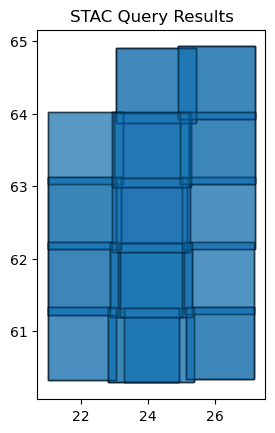

In [17]:
fig = gdf.plot(
    edgecolor="black",
    alpha=0.05,
)
_ = fig.set_title("STAC Query Results")

To plot items with a zoomable map see this example: https://stacspec.org/en/tutorials/access-sentinel-2-data-aws#Plot-STAC-Items-on-a-Map

## Retrieving data

Create `Xarray DataArray` datacube from the STAC items. 

Using the defaults, our data will be in its native coordinate reference system, at the finest resolution. But many also other values can be set here. 

* `bounds` - datacube bounds, use smaller bbox in data's UTM coordinate reference system, around the original search point and with width and height of `buffer`.
* `epsg` - datacube coordinate system, given as EPSG code.
* `chunksize` - how big part of data is analysed at once, see also [Dask chunksize](https://github.com/csc-training/geocomputing/blob/master/python/STAC/Readme.md#dask-chunksize). 
* `resolution` - pixel size
* See [stackstac.stac()](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html#stackstac.stack) documentation for more details. 

This will be fast, because the actual data is not fetched yet. How does the datacube look like? How many dimensions does it have?

In [18]:
%time 
x, y = pyproj.Proj("EPSG:3067")(lon, lat)
buffer = 5000 

cube = stackstac.stack(
    items=item_collection,
    bounds=(x-buffer, y-buffer, x+buffer, y+buffer), 
    assets=["b04", "b03", "b02"],
    # chunksize=(-1,1,2048,2048),
    # resolution=50,
    # resampling=Resampling.bilinear
    epsg=3067
).squeeze() 
# When item_collection contains multiple epsg's, epsg value needs to be provided
cube

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


<xarray.DataArray 'stackstac-9176468674b6c435727ed050fe4742fe' (time: 6,
                                                                band: 3,
                                                                y: 501, x: 501)>
dask.array<fetch_raster_window, shape=(6, 3, 501, 501), dtype=float64, chunksize=(1, 1, 501, 501), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2021-08-01 2021-08-11 ... 2021-09-21
    id              (time) <U53 'Sentinel-2_global_mosaic_dekadi_2021-08-01_2...
  * band            (band) <U3 'b04' 'b03' 'b02'
  * x               (x) float64 3.81e+05 3.81e+05 3.81e+05 ... 3.91e+05 3.91e+05
  * y               (y) float64 6.677e+06 6.677e+06 ... 6.667e+06 6.667e+06
    gsd             float64 20.0
    proj:transform  object {0, 7799840, 1, -20, 20, 50200}
    proj:epsg       int64 3067
    start_datetime  (time) <U29 '2021-08-01T00:00:00.000+00:00' ... '2021-09-...
    end_datetime    (time) <U29 '2021-08-10T23:59:59.000+00:00' ... '2021-09-...
    title           (band) <U3 'b04' 'b03' 'b02'
    epsg            int64 3067
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(380980.0, 6667440.0, 391000.0,...
    crs:         epsg:3067
    transform:   | 20.00, 0.00, 380980.00|\n| 0.00,-20.00, 6677460.00|\n| 0.0...
    resolution:  20.0

Use xarray's `resample` to create 1-month median composites. Note that we still only work on metadata/lazy-loaded data, hence we have not downloaded any data yet.

In [19]:
monthly = cube.resample(time="MS").median("time", keep_attrs=True)
monthly

<xarray.DataArray 'stackstac-9176468674b6c435727ed050fe4742fe' (time: 2,
                                                                band: 3,
                                                                y: 501, x: 501)>
dask.array<stack, shape=(2, 3, 501, 501), dtype=float64, chunksize=(1, 3, 501, 501), chunktype=numpy.ndarray>
Coordinates:
  * band            (band) <U3 'b04' 'b03' 'b02'
  * x               (x) float64 3.81e+05 3.81e+05 3.81e+05 ... 3.91e+05 3.91e+05
  * y               (y) float64 6.677e+06 6.677e+06 ... 6.667e+06 6.667e+06
    gsd             float64 20.0
    proj:transform  object {0, 1, 7799840, -20, 20, 50200}
    proj:epsg       int64 3067
    title           (band) <U3 'b04' 'b03' 'b02'
    epsg            int64 3067
  * time            (time) datetime64[ns] 2021-08-01 2021-09-01
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(380980.0, 6667440.0, 391000.0,...
    crs:         epsg:3067
    transform:   | 20.00, 0.00, 380980.00|\n| 0.00,-20.00, 6677460.00|\n| 0.0...
    resolution:  20.0

So far no data has been downloaded, nor anything computed with actual data. In this example the final data size is very small, but Dask is good also in handling much bigger amounts of data, also bigger than fits to memory.

It is also possible to [visualize, what Dask is going to do](https://docs.dask.org/en/stable/graphviz.html#). Sometimes some optimizations might be possible to make the graph better.

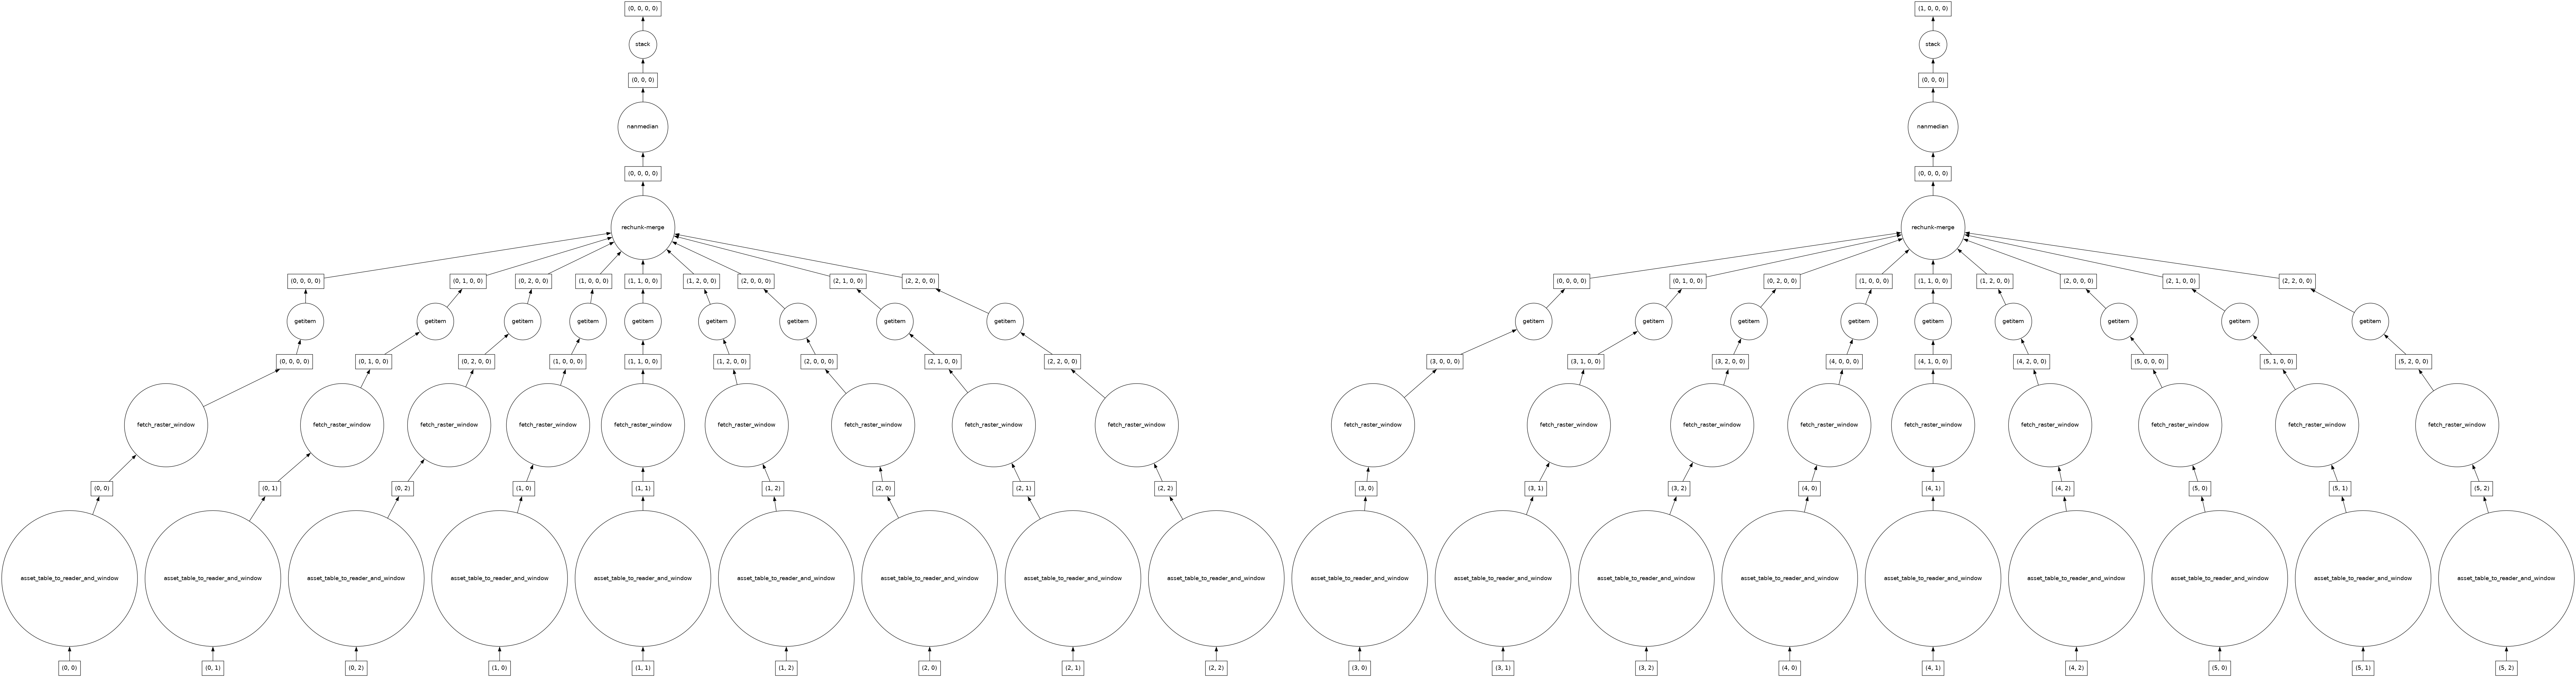

In [20]:
import dask
dask.visualize(monthly)

To start the data download and analysis process `compute()` could be used, but usually it is skipped and delayed even further until saving or plotting the data. The process can be followed from Dask Dashboard or Dask Lab Extension. Depending on the amount of data, this will take some time.

In [21]:
# %%time
# data = monthly.compute()

Show the resulting images.

CPU times: user 447 ms, sys: 107 ms, total: 554 ms
Wall time: 3.53 s


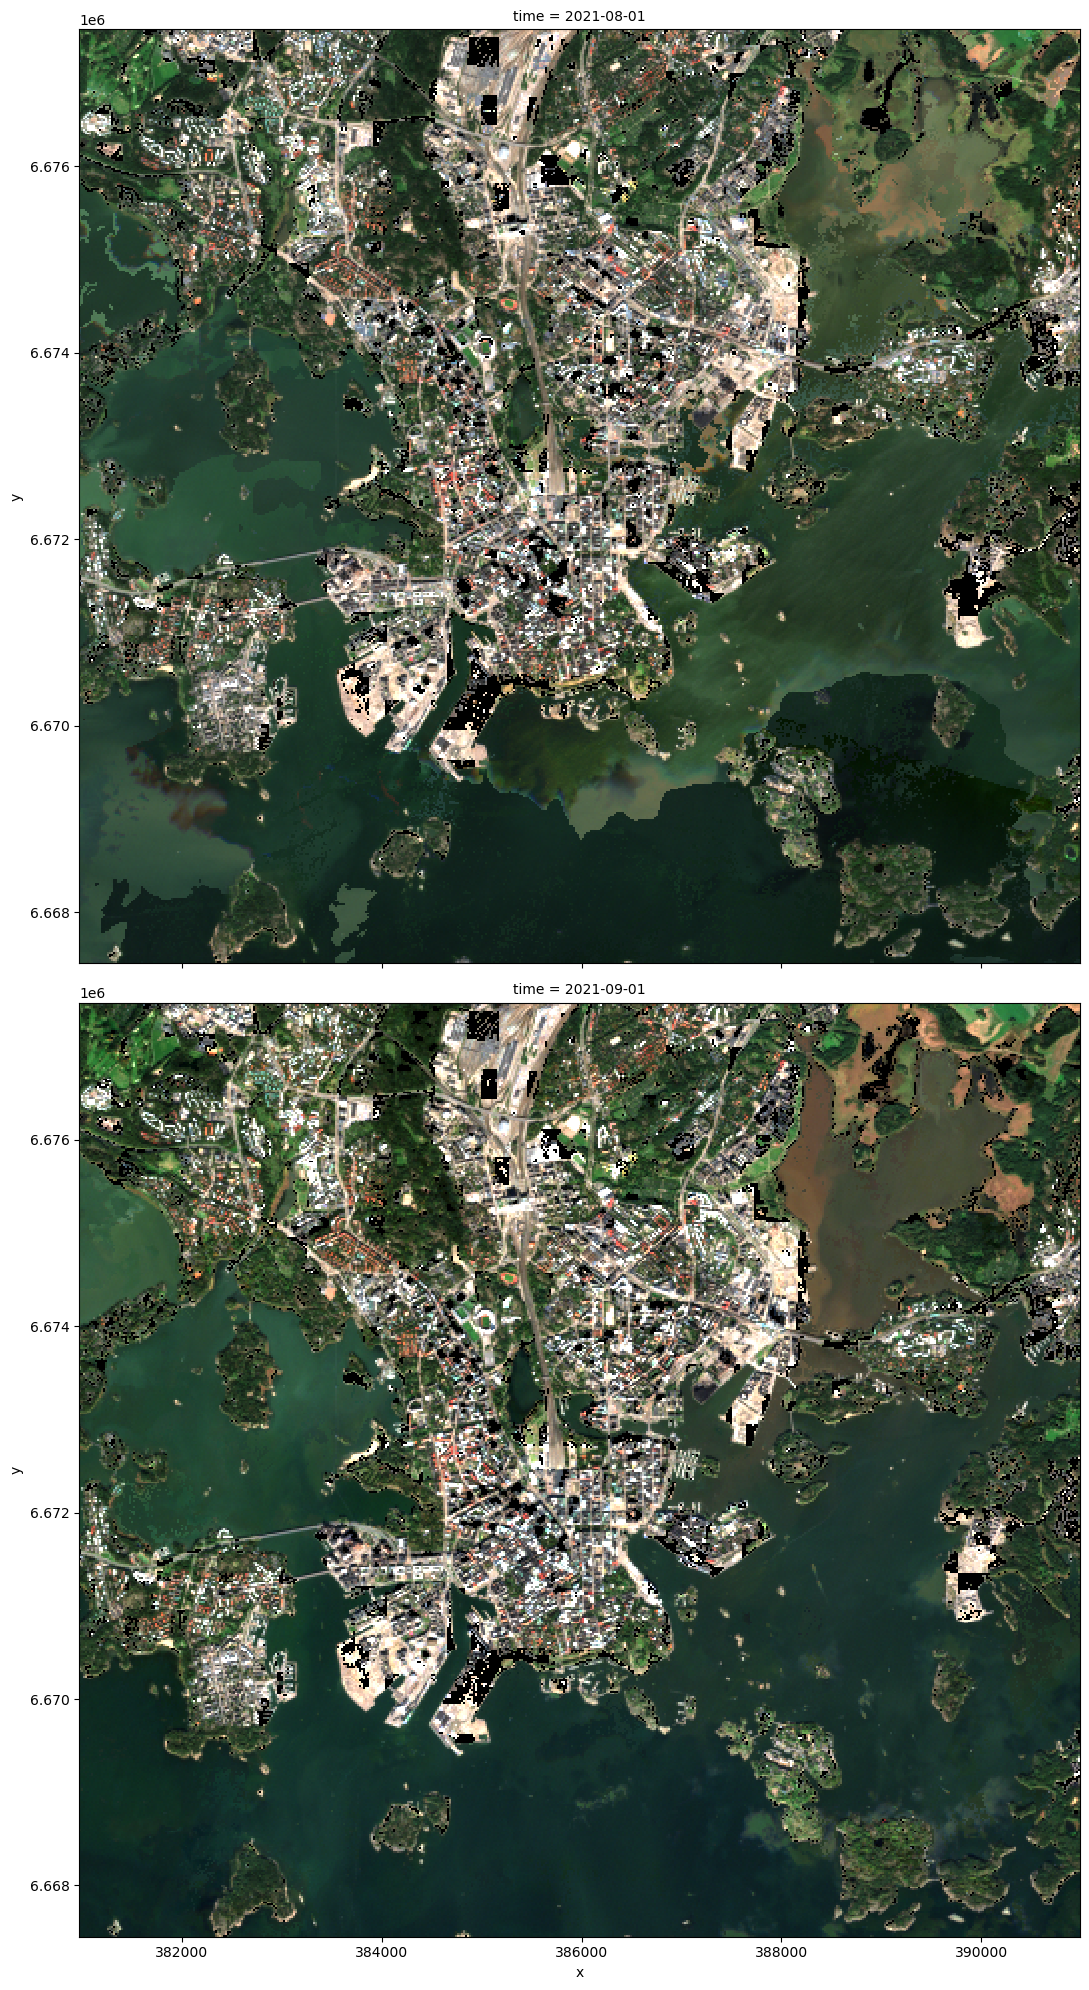

In [22]:
%%time
monthly.plot.imshow(row="time", rgb="band", robust=True, size=10);

Save the result to a file:
* `Rioxarray` currently supports writing only one dimension besides the x and y. We have both bands and time, so for saving we select only one month here.
* [For parallel writing with Dask](https://corteva.github.io/rioxarray/html/examples/dask_read_write.html#) use the Lock and `tiled`. 
* It is important to use absolute path for file name.

In [23]:
%%time
output_file = os.path.join(os.getcwd(), "ndvi.tif")
mean_ndvi_tiff = monthly.isel(time=0).rio.to_raster(
    output_file,
    lock=Lock(name="rio", client=client),
    tiled=True,
)

CPU times: user 57.4 ms, sys: 5.99 ms, total: 63.4 ms
Wall time: 629 ms


Close Dask cluster, rest of this example does not benefit from Dask.

In [24]:
client.close()

## Other tools
It is possible to use the STAC also when working with rasterio or other tools, but then the URLs must be manually retrieved.

### One item info
See detailed info about one Item.

In [25]:
i = 0
item = item_collection[i]
print(f"{i}: {item}")
print(f"{i}: {item.bbox}")
print(f"{i}: {item.properties}")
print(f"Available assets: {item.assets.keys()}")
for key in item.assets.keys():
        print(f"{key}: {item.assets[key]}")

0: <Item id=Sentinel-2_global_mosaic_dekadi_2021-09-21_2021-09-30>
0: [15.201371, 59.14202, 36.021476, 70.077018]
0: {'start_datetime': '2021-09-21T00:00:00.000+00:00', 'end_datetime': '2021-09-30T23:59:59.000+00:00', 'datetime': '2021-09-21T00:00:00Z', 'gsd': 20.0, 'proj:epsg': 3067, 'proj:transform': [20, 0, 50200, 0, -20, 7799840, 0, 0, 1]}
Available assets: dict_keys(['medoid_mos', 'valid_obs', 'quality_scene_classification', 'quality_snow_confidence', 'quality_cloud_confidence', 'b01', 'b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b11', 'b12', 'view_azimuth_mean', 'sun_azimuth', 'view_zenith_mean', 'sun_zenith', 'source_index', 'quality_aot'])
medoid_mos: <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_medoid_mos/s2m_sdr_20210921-20210930_medoid_mos_r20m.tif>
valid_obs: <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_valid_obs/s2m_sdr_20210921-20210930_valid_obs_r20m.tif>
quality_scene_classification: <Asset href=https://pta.data.lit.fmi.fi/sen2/s2m_quality_scene_clas

## Working with rasterio or other tools

Rasterio is widely used Python package for raster data.

In [26]:
import rasterio
from rasterio.plot import show
from rasterio.windows import Window

Select item and asset, retrieve URL.

In [27]:
url = item_collection[3].assets['b02'].href
url

'https://pta.data.lit.fmi.fi/sen2/s2m_b02/s2m_sdr_20210821-20210831_b02_r20m.tif'

Open with rasterio, see basic info

In [28]:
%time
dataset = rasterio.open(url)
print(f"Transform: {dataset.transform}")
print(f"Transform: {dataset.shape}")
print(f"Transform: {dataset.crs}")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
Transform: | 20.00, 0.00, 50200.00|
| 0.00,-20.00, 7799840.00|
| 0.00, 0.00, 1.00|
Transform: (60869, 39590)
Transform: EPSG:3067


Plot with rasterio a small part of the image

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


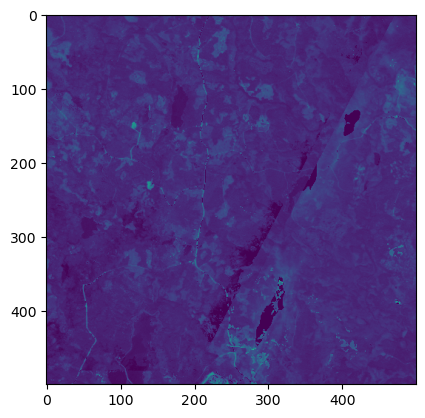

<Axes: >

In [29]:
%time
show(dataset.read(window=Window(20000, 20000, 500, 500)))

Use GDAL with the URL.

In [30]:
!gdalinfo /vsicurl/{url}

Driver: GTiff/GeoTIFF
Files: /vsicurl/https://pta.data.lit.fmi.fi/sen2/s2m_b02/s2m_sdr_20210821-20210831_b02_r20m.tif
Size is 39590, 60869
Coordinate System is:
PROJCRS["ETRS89 / TM35FIN(E,N)",
    BASEGEOGCRS["ETRS89",
        ENSEMBLE["European Terrestrial Reference System 1989 ensemble",
            MEMBER["European Terrestrial Reference Frame 1989"],
            MEMBER["European Terrestrial Reference Frame 1990"],
            MEMBER["European Terrestrial Reference Frame 1991"],
            MEMBER["European Terrestrial Reference Frame 1992"],
            MEMBER["European Terrestrial Reference Frame 1993"],
            MEMBER["European Terrestrial Reference Frame 1994"],
            MEMBER["European Terrestrial Reference Frame 1996"],
            MEMBER["European Terrestrial Reference Frame 1997"],
            MEMBER["European Terrestrial Reference Frame 2000"],
            MEMBER["European Terrestrial Reference Frame 2005"],
            MEMBER["European Terrestrial Reference Frame 2